# Project Data Lab

## Imports

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, size, explode, regexp_replace, when, collect_list, expr
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, FloatType
from sentence_transformers import SentenceTransformer
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import numpy as np
from scipy.spatial.distance import cosine
import re
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from matplotlib import cm
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.functions import array_to_vector

In [0]:
companies = spark.read.parquet("/dbfs/linkedin_train_data")
people = spark.read.parquet("/dbfs/linkedin_people_train_data")

In [0]:
# sampling the data so we dont have to wait 4 hours 
N = 2000
n = N
# Copy dataframe and select only a few rows
people_df = people.sample(False, n / people.count())

def extract_all(column_name):
    """
    Extracts all values from a column
    @param column_name: The name of the column
    @return: None
    """
    global people_df
    people_df = people_df.withColumn(
        f"all_{column_name}s",
        F.expr(f"""
            FILTER(
                CONCAT(
                    transform(experience, x -> x['{column_name}']),
                    ARRAY(current_company['{column_name}'])
                ),
                x -> x is not null and x != 'null'
            )
        """)
    )

extract_all('company_id')
extract_all('title')

columns = ['id', 'all_company_ids', 'all_titles']
# people_df = people_df.select(*[col(c) for c in columns]) 

# people_df.display()

## Part 1 - Map Users Into Meta Industries:
1. Get all of the user's titles. 
2. Encode and compute their average enmbedding.
3. Assign the meta industry with the lowest similarity score. 

In [0]:
# Count total people
total_count = people_df.count()

# Count people where 'experience_ids' is empty
empty_experience_count = people_df.filter(F.size("all_titles") == 0).count()

# Calculate percentage
percentage_empty = (empty_experience_count / total_count) * 100 if total_count > 0 else 0

print(f"Percentage of people with no experience: {percentage_empty:.2f}%")

Percentage of people with no experience: 3.05%


In [0]:
# Filter rows with empty titles
people_df = people_df.filter(F.size("all_titles") > 0)

In [0]:
meta_industries_jobs = {
    'Healthcare and Medical': [
        'Doctor',
        'Nurse',
        'Pharmacist',
        'Medical Technician',
        'Surgeon',
        'Physical Therapist',
        'Radiologist',
        'Dentist',
        'Psychologist',
        'Paramedic'
    ],
    'Media and Entertainment': [
        'Journalist',
        'Film Director',
        'Actor',
        'Graphic Designer',
        'Photographer',
        'Video Editor',
        'Music Producer',
        'Animator',
        'Public Relations Specialist',
        'Content Creator'
    ],
    'Technology': [
        'Software Engineer',
        'Data Scientist',
        'Cybersecurity Analyst',
        'IT Support Specialist',
        'Web Developer',
        'AI/ML Engineer',
        'DevOps Engineer',
        'Database Administrator',
        'Game Developer',
        'Network Administrator'
    ],
    'Government and Public Policy': [
        'Policy Analyst',
        'Legislative Assistant',
        'Public Relations Officer',
        'City Planner',
        'Government Program Manager',
        'Diplomat',
        'Civil Servant',
        'Economist',
        'Social Worker',
        'Law Enforcement Officer'
    ],
    'Real Estate and Construction': [
        'Real Estate Agent',
        'Architect',
        'Construction Manager',
        'Civil Engineer',
        'Surveyor',
        'Property Manager',
        'Interior Designer',
        'Urban Planner',
        'Structural Engineer',
        'Quantity Surveyor'
    ],
    'Financial and Investment': [
        'Financial Analyst',
        'Investment Banker',
        'Accountant',
        'Auditor',
        'Insurance Agent',
        'Loan Officer',
        'Stockbroker',
        'Tax Consultant',
        'Risk Manager',
        'Wealth Manager'
    ],
    'Transportation and Logistics': [
        'Logistics Coordinator',
        'Supply Chain Manager',
        'Truck Driver',
        'Freight Broker',
        'Warehouse Manager',
        'Customs Officer',
        'Air Traffic Controller',
        'Delivery Driver',
        'Fleet Manager',
        'Import/Export Coordinator'
    ],
    'Services': [
        'Customer Service Representative',
        'Event Planner',
        'Travel Agent',
        'Hotel Manager',
        'Personal Trainer',
        'Hair Stylist',
        'Security Guard',
        'Housekeeper',
        'Barista',
        'Waiter/Waitress'
    ],
    'Education and Training': [
        'Teacher',
        'Professor',
        'Tutor',
        'School Administrator',
        'Curriculum Developer',
        'Instructional Designer',
        'Corporate Trainer',
        'Education Consultant',
        'Librarian',
        'Special Education Teacher'
    ],
    'Manufacturing': [
        'Production Manager',
        'Quality Control Inspector',
        'Assembly Line Worker',
        'Industrial Engineer',
        'Machine Operator',
        'Supply Chain Analyst',
        'Mechanical Technician',
        'Warehouse Worker',
        'Manufacturing Engineer',
        'Materials Manager'
    ],
    'Retail and Consumer Goods': [
        'Retail Sales Associate',
        'Store Manager',
        'Merchandiser',
        'Buyer',
        'Cashier',
        'E-commerce Manager',
        'Inventory Specialist',
        'Customer Support Specialist',
        'Brand Manager',
        'Visual Merchandiser'
    ],
    'Miscellaneous': [
    "Ranch Manager",  # Ranching
    "Livestock Handler",  # Ranching
    "Petroleum Engineer",  # Oil and Gas
    "Oil Rig Worker",  # Oil and Gas
    "Mining Engineer",  # Mining
    "Geologist",  # Mining
    "Sports Coach",  # Spectator Sports
    "Event Coordinator",  # Spectator Sports
    "Nanotechnology Research Scientist",  # Nanotechnology Research
    "Materials Engineer",  # Nanotechnology Research
    "Chief Executive Officer (CEO)",  # Executive Offices
    "Military Officer",  # Armed Forces
    "Utility Engineer",  # Utilities
    "Non-Profit Director",  # Non-profit Organizations
    "Recreational Facility Manager",  # Recreational Facilities
    "Clergy Member",  # Religious Institutions
    "Fisheries Biologist",  # Fisheries
    "Factory Worker",  # Manufacturing
    "Librarian",  # Libraries
    "Writer"  # Artists and Writers
]
}


In [0]:
models = {
    'bert': 'all-MiniLM-L6-v2',
    'roberta': 'all-distilroberta-v1',
    'distilbert': 'multi-qa-distilbert-cos-v1'
}

In [0]:
def add_meta_industry(people_df, model_name, model_tag='AI'):
    model = SentenceTransformer(model_name)

    def average_embedding(titles):
        embeddings = model.encode(titles)  # Encode all titles    
        avg_embedding = np.mean(embeddings, axis=0)  # Average the embeddings
        return avg_embedding.tolist()  # Return as a list
    
    meta_industries_names = list(meta_industries_jobs.keys())

    # Generate embeddings for each industry
    industry_embeddings = [average_embedding(meta_industries_jobs[industry]) for industry in meta_industries_names]

    avg_embedding_udf = F.udf(average_embedding, ArrayType(FloatType()))

    # Add the 'title_vector' column by applying the UDF
    people_df = people_df.withColumn(f'{model_tag}_title_vector', avg_embedding_udf(F.col('all_titles')))

    def closest_meta_industry(title_vector):
        # Calculate cosine similarities between the title vector and each industry embedding
        similarities = [1 - cosine(title_vector, industry_embedding) for industry_embedding in industry_embeddings]
        max_sim_index = np.argmax(similarities)  # Get index of the highest similarity
        return meta_industries_names[max_sim_index]  # Return the corresponding meta industry

    closest_meta_industry_udf = F.udf(closest_meta_industry, F.StringType())
    people_df = people_df.withColumn(f'{model_tag}_meta_industry', closest_meta_industry_udf(F.col(f'{model_tag}_title_vector'))).drop(f'{model_tag}_title_vector')

    return people_df

In [0]:
for model in models:
    people_df = add_meta_industry(people_df, models[model], model_tag=model)

/databricks/python/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [0]:
people_df.display()

about avatar certifications city country_code current_company current_company:company_id current_company:name education educations_details experience followers following groups id languages name people_also_viewed position posts recommendations recommendations_count timestamp url volunteer_experience сourses all_company_ids all_titles bert_meta_industry roberta_meta_industry distilbert_meta_industry null https://media.licdn.com/dms/image/C5103AQGjDOnaJzjiSQ/profile-displayphoto-shrink_800_800/0/1517407160405?e=2147483647&v=beta&t=i2XCyckAPX8LCE5gv03BUGZ3M3FzFb94p53b7NHrDDQ List(List(null, -, CPR Certified)) Pittsburgh, Pennsylvania, United States US List(childrens-hospital-oakland, Childrens Hospital Oakland, https://www.linkedin.com/company/childrens-hospital-oakland?trk=public_profile_topcard-current-company, Childrens Hospital Oakland, Volunteer Clinical Research Assistant at Childrens Hospital Oakland) childrens-hospital-oakland Childrens Hospital Oakland List(List(Bachelor of Science (BS), 2018, Psychology and Computer Science, 2013 - 2018, 2013, University of Pittsburgh, https://www.linkedin.com/school/university-of-pittsburgh/?trk=public_profile_school_profile-section-card_image-click)) University of Pittsburgh List(List(null, null, 1. Adapted to a fast paced work environment 2. Learned techniques in psychology research 3. Obtained skills in data input/management with Microsoft Excel 4. Developing skills in teamwork and communication 1. Adapted to a fast paced work environment 2. Learned techniques in psychology research 3. Obtained skills in data input/management with Microsoft Excel 4. Developing skills in teamwork and communication, Dec 2015 - Present 7 years 10 months, 7 years 10 months, Present, Greater Pittsburgh Area, null, Dec 2015, Childrens Hospital Oakland, https://www.linkedin.com/company/childrens-hospital-oakland?trk=public_profile_experience-item_profile-section-card_subtitle-click, Volunteer Clinical Research Assistant, null), List(null, null, 1. Trained in noticing signs of mental health issues 2. Established as a resource and leader for over 50 residents 3. Facilitating and leading programs to build a healthy floor community 4. Communication among coworkers across campus to provide a fun and safe environment for students 1. Trained in noticing signs of mental health issues 2. Established as a resource and leader for over 50 residents 3. Facilitating and leading programs to build a healthy floor community 4. Communication among coworkers across campus to provide a fun and safe environment for students, Sep 2015 - Present 8 years 1 month, 8 years 1 month, Present, Greater Pittsburgh Area, null, Sep 2015, University of Pittsburgh, https://www.linkedin.com/company/university-of-pittsburgh?trk=public_profile_experience-item_profile-section-card_subtitle-click, Resident Assistant, null), List(null, null, 1. Conflict Resolution Training 2. Received two weeks of team building training 3. High capacity for creativity and patience after working with children 4. Maintained a leadership role in my work place 5. 400+ hours of volunteer work 1. Conflict Resolution Training 2. Received two weeks of team building training 3. High capacity for creativity and patience after working with children 4. Maintained a leadership role in my work place 5. 400+ hours of volunteer work, May 2015 Aug 2015 4 months, 4 months, Aug 2015, Greater Pittsburgh Area, null, May 2015, AmeriCorps, https://www.linkedin.com/company/americorps?trk=public_profile_experience-item_profile-section-card_subtitle-click, KEYS Service Member, null)) 19 19 List() aaron-jackson-5bb02b115 List(List(-, English)) Aaron Jackson List() Volunteer Clinical Research Assistant at Childrens Hospital Oakland List() List() null 2023-09-04 https://www.linkedin.com/in/aaron-jackson-5bb02b115 List() List(List(0422, Cognitive Psychology), List(0401, Intermediate Programming with Java), List(0007, Intro to Programming with Java)) List(childrens-hospital-oakland) List(Volu

### Distribution:

### Plot Distributions:

In [0]:
model_names = models.keys()

In [0]:
def calculate_percentages(people_df, model_name):
    total_count = people_df.count()
    value_counts = people_df.groupBy(f"{model_name}_meta_industry").count()
    percentages = value_counts.withColumn("percentage", (F.col("count") / total_count) * 100)
    percentages_dict = {row[f"{model_name}_meta_industry"]: row["percentage"] for row in percentages.collect()}

    return percentages_dict

model_percentages = dict()
for model in models:
    model_percentages[model] = calculate_percentages(people_df, model)

In [0]:
from builtins import sum
for model in models:
    print(len(model_percentages[model].values()))
    print(sum(model_percentages[model].values()))

12
100.0
12
100.00000000000001
12
100.0


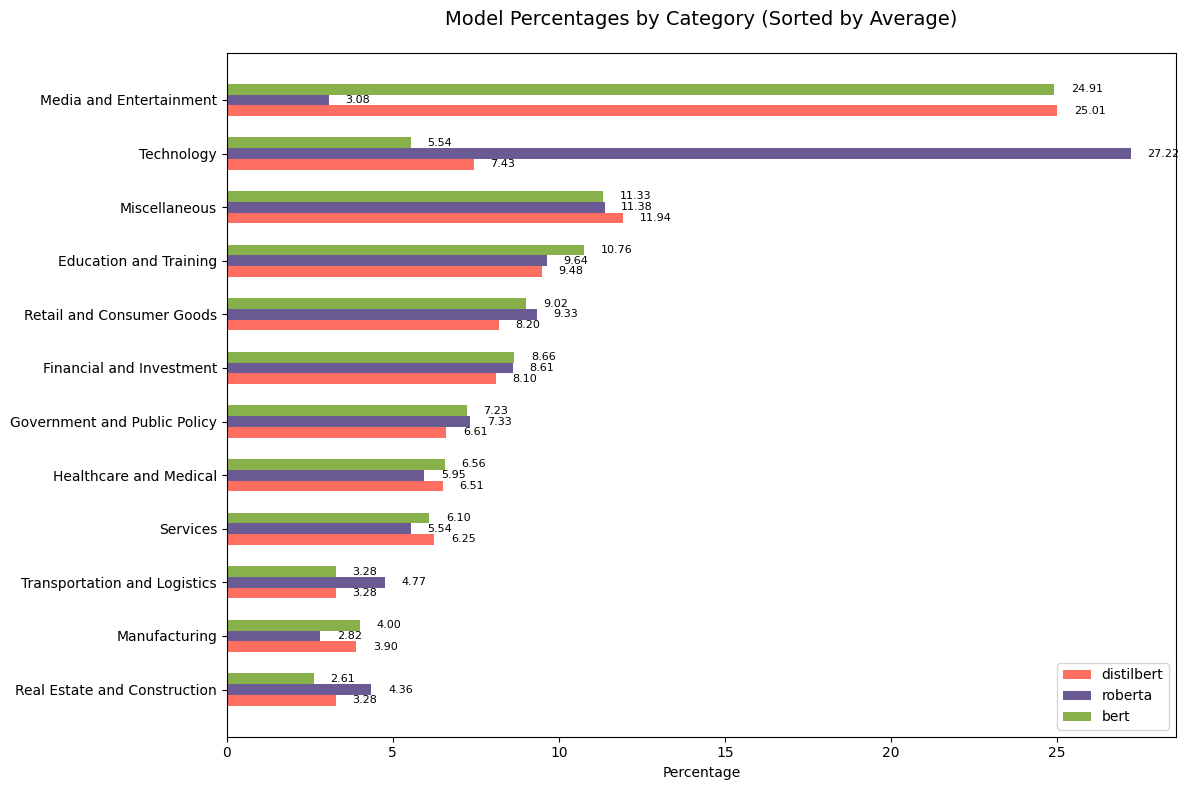

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Extract categories and model data
categories = list(model_percentages['bert'].keys())
models = list(model_percentages.keys())

# Prepare data for plotting
data = {model: [model_percentages[model][cat] for cat in categories] for model in models}

# Calculate average for each category
averages = [np.mean([data[model][i] for model in models]) for i in range(len(categories))]

# Sort categories by average
sorted_indices = np.argsort(averages)
sorted_categories = [categories[i] for i in sorted_indices]
sorted_data = {model: [data[model][i] for i in sorted_indices] for model in models}

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Bar width
bar_width = 0.2

# Positions for the bars
indices = np.arange(len(sorted_categories))

# Define a more appealing color scheme
colors = ['#FF6F61', '#6B5B95', '#88B04B']  # Red, Purple, Green

# Plot bars for each model (red on top)
for i, model in enumerate(models[::-1]):  # Reverse order to plot red on top
    bars = ax.barh(indices + i * bar_width, sorted_data[model], height=bar_width, label=model, color=colors[i])
    
    # Add value labels next to each bar
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', va='center', fontsize=8)

# Set y-ticks and labels
ax.set_yticks(indices + bar_width)
ax.set_yticklabels(sorted_categories)

# Add labels and title
ax.set_xlabel('Percentage')
ax.set_title('Model Percentages by Category (Sorted by Average)', fontsize=14, pad=20)

# Add legend
ax.legend(loc='lower right')

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()